In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import itertools
import seaborn as sns
import string

In [2]:
#DATA_PATH = f"/kaggle/input/rue-and-fake-news"

In [5]:
# Reading the dataset
df_Fake = pd.read_csv("https://raw.githubusercontent.com/DATA-606-FALL-2022/Data606_ShivaniReddy/main/Data/Fake.csv")
df_True = pd.read_csv("https://raw.githubusercontent.com/DATA-606-FALL-2022/Data606_ShivaniReddy/main/Data/True.csv")
df_Fake.shape, df_True.shape

((23481, 4), (21417, 4))

#Data Cleaning

In [6]:
# Add flag to track fake and real
df_Fake['target'] = 'fake'
df_True['target'] = 'true'

# Concatenate dataframes
data = pd.concat([df_Fake, df_True]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)
data.head()

,title,text,subject,date,target
0,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017",true
1,Filmmaker Michael Moore launches 'TrumpiLeaks'...,LOS ANGELES (Reuters) - Documentary filmmaker ...,politicsNews,"June 6, 2017",true
2,U.N. says still determining if Myanmar crisis ...,GENEVA (Reuters) - The United Nations has yet ...,worldnews,"October 18, 2017",true
3,Islamic State's footprint spreading in norther...,NAIROBI (Reuters) - A militant faction loyal t...,worldnews,"November 8, 2017",true
4,BOXING LEGEND GEORGE FOREMAN Reveals How Trump...,You can t be black and support President Trump...,left-news,"Aug 25, 2017",fake


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [9]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

In [10]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,true
1,Filmmaker Michael Moore launches 'TrumpiLeaks'...,LOS ANGELES (Reuters) - Documentary filmmaker ...,politicsNews,true
2,U.N. says still determining if Myanmar crisis ...,GENEVA (Reuters) - The United Nations has yet ...,worldnews,true
3,Islamic State's footprint spreading in norther...,NAIROBI (Reuters) - A militant faction loyal t...,worldnews,true
4,BOXING LEGEND GEORGE FOREMAN Reveals How Trump...,You can t be black and support President Trump...,left-news,fake


- Concatenating Title and Text. Title usually summaries the articles in one or two sentences which provides useful information to identify click bait articles.

In [11]:
data['text'] = data['title'] + " " + data['text']
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,Alabama official to certify Senator-elect Jone...,politicsNews,true
1,Filmmaker Michael Moore launches 'TrumpiLeaks'...,politicsNews,true
2,U.N. says still determining if Myanmar crisis ...,worldnews,true
3,Islamic State's footprint spreading in norther...,worldnews,true
4,BOXING LEGEND GEORGE FOREMAN Reveals How Trump...,left-news,fake


In [12]:
def plot_bar_chart(x,y,figsize=(7,5), xlabel=None, ylabel=None, title=None):
    
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=pd.Series(x), y=pd.Series(y))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    rects = ax.patches
    for rect, label in zip(rects, y):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, 
            height + 3, label, ha="center", va="bottom"
        )
    plt.xticks(rotation=90)
    plt.show()
    
    return ax

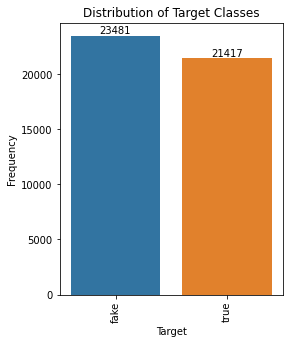

In [13]:
# How many fake and real articles?
h, v = zip(*data['target'].value_counts().items())
plot_bar_chart(h, v, figsize=(4,5), 
    xlabel="Target", ylabel="Frequency", title="Distribution of Target Classes")

- The classes (fake & true) are nearly balanced. The data is not suffering from imbalance.

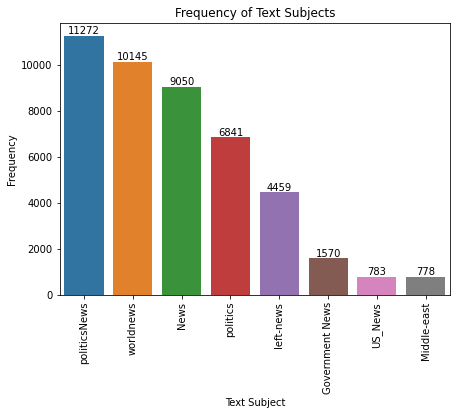

In [14]:
h, v = zip(*data['subject'].value_counts().items())
plot_bar_chart(h, v, xlabel="Text Subject", ylabel="Frequency", 
               title="Frequency of Text Subjects")

- From the subjects (politicsNews, Government News, politics), it is clear that the articles belongs to political news. These more like a news article sources rather than proper subjects.

#### Text Preprocessing

- As the text is scraped from online publications, preprocessing the text is neccessary to remove hyperlinks, urls, emojis and clean the texts.

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
from nltk.corpus import stopwords
from nltk import word_tokenize
import re

eng_stops = stopwords.words('english')

def preprocess_text(t):
    lower_text = t.lower()
    tex = re.sub(r"[0-9]+", " ", lower_text)
    tex = re.sub(r"[^\'\,\_a-zA-Z\s]", " ", tex)
    tex = re.sub(r"(http|https)?://(www\.)?|[\w\.-]+@[\w\.-]+|<[^>]*>", " ", tex)
    words = [x.strip() for x in word_tokenize(tex) if x not in eng_stops]
    words = [w.strip(".") for w in words if len(w)>=3]
    words = [w for w in " ".join(words).split(" ") if len(w)>= 3]
    if len(words):
        return " ".join(words)
    return np.nan

In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
data['text_words'] = data['text'].apply(preprocess_text)
data['num_words'] = data['text_words'].apply(lambda x:len(x.split(" ")))

# Exploratory Data Analysis

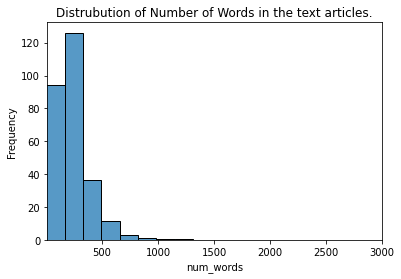

In [19]:
ax = sns.histplot(data['num_words'], stat='frequency', bins=30)
_ = ax.axis(xmin=10, xmax=3000)
_ = ax.set_title("Distrubution of Number of Words in the text articles.")

- This distrubution plot infers that most articles are having les than 500 words.

Text(0.5, 1.0, 'Distrubution of Number of Words by Target.')

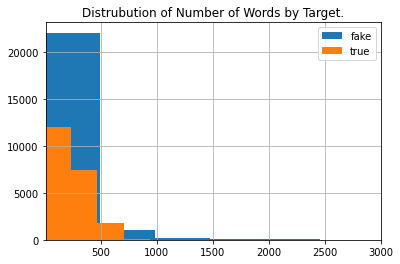

In [20]:
ax, _ = data.groupby('target')['num_words'].hist(legend=True)
_ = ax.axis(xmin=10, xmax=3000)
ax.set_title("Distrubution of Number of Words by Target.")

- the distrubution of words in fake v/s true artciles is similar in nature. While fake are in between 1-500 words. There are more true ones with less 250 words.

In [21]:
from wordcloud import WordCloud

def plot_word_cloud(counter, max_words=50):
    plt.figure(figsize=(12,5))
    word_cloud = WordCloud(max_font_size=100,max_words=max_words).generate_from_frequencies(counter)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title("Word Cloud of Frequently Mentioned Words")
    plt.axis("off")
    plt.show()

In [22]:
from nltk.probability import FreqDist
from nltk.util import ngrams

single_words = []
two_grams = []
three_grams = []

for r in data['text_words']:
    # store single words
    ws = r.split(" ")
    single_words.extend(ws)
    # get and store n grams
    ws = [w for w in r.split(" ") if len(w)]
    try:
        two_grams.extend(['_'.join(g) for g in ngrams(ws, 2)])
        three_grams.extend(['_'.join(g) for g in ngrams(ws, 3)])
    except Exception as exp:
        pass

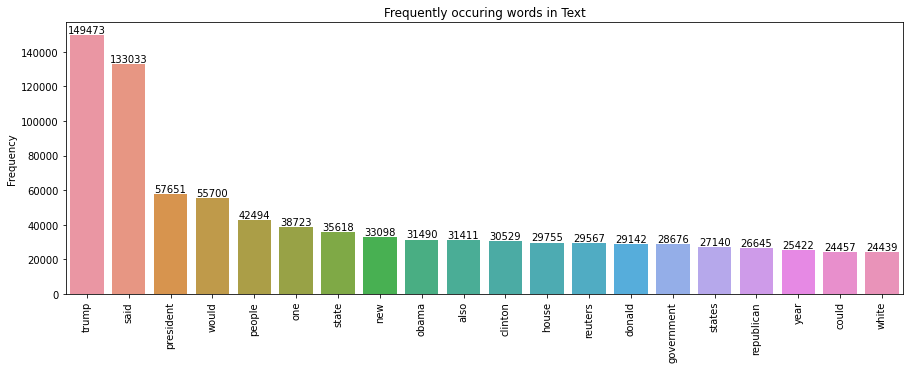

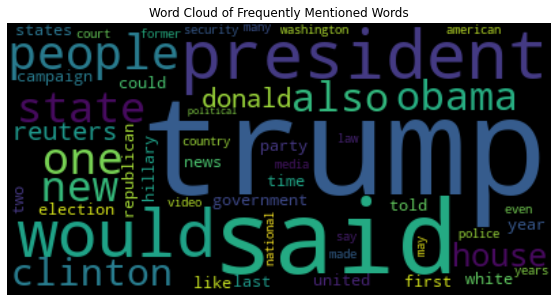

In [23]:
word_counts = FreqDist(single_words)
h, v = zip(*word_counts.most_common(20))
_ = plot_bar_chart(h, v, figsize=(15,5), ylabel="Frequency", 
               title="Frequently occuring words in Text")
print("\n")
_ = plot_word_cloud(word_counts)

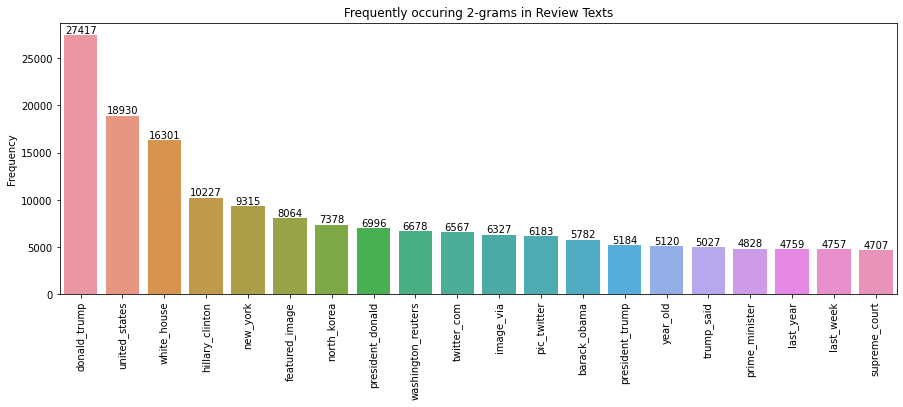

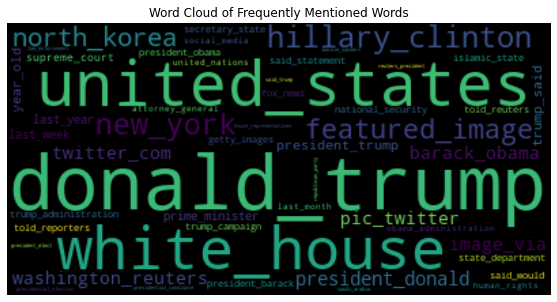

In [24]:
gram_counts = FreqDist(two_grams)
h, v = zip(*gram_counts.most_common(20))
_ = plot_bar_chart(h, v, figsize=(15,5), ylabel="Frequency", 
               title="Frequently occuring 2-grams in Review Texts")
print("\n")
_ = plot_word_cloud(gram_counts)

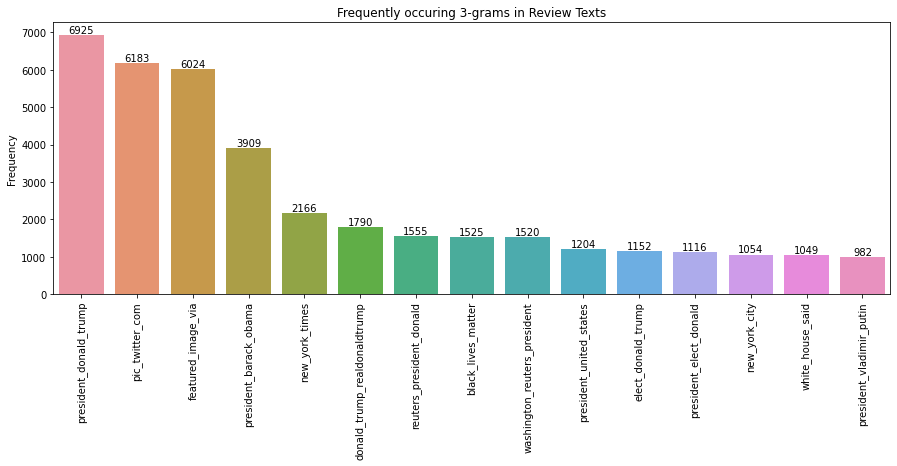

In [25]:
gram_counts = FreqDist(three_grams)
h, v = zip(*gram_counts.most_common(15))
_ = plot_bar_chart(h, v, figsize=(15,5), ylabel="Frequency", 
               title="Frequently occuring 3-grams in Review Texts")
print("\n")

- As the text belongs to political news, we can that mostly frequently repeated terms are donlad trump, barack obama, President, which indicates the period and topic of possibly presidential elections.

Word Clouds by Fake & Real Articles

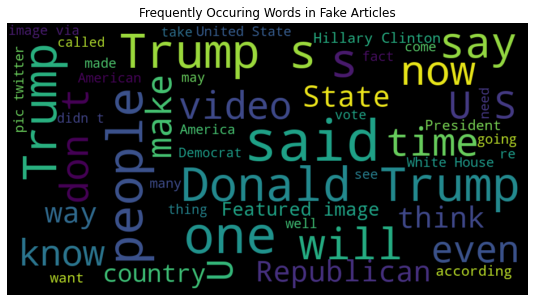

In [26]:
# Word cloud for fake news
fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width=920, height=480, max_words=50,
                      max_font_size = 100).generate(all_words)
plt.figure(figsize=(12,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Frequently Occuring Words in Fake Articles")
plt.axis("off")
plt.show()

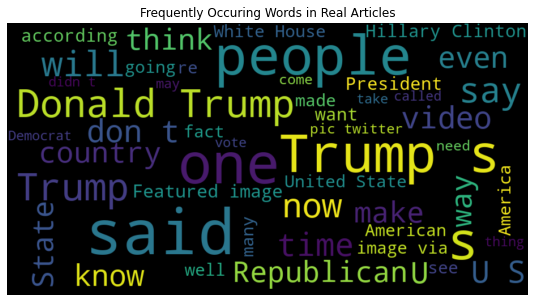

In [27]:
# Word cloud for real news
real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width=920, height=480,max_words=50,
                      max_font_size = 110).generate(all_words)
plt.figure(figsize=(12,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Frequently Occuring Words in Real Articles")
plt.axis("off")
plt.show()

The frequently occuring words are very similar in both true & fake articles,so they dont add any significant value for classifications these. This suggests that we can safely ignore them from features by adjusting the min_df or max_df values while converting the texts into features.

##### text quality/readability stats

In [28]:
!pip -q install textstat

     |████████████████████████████████| 105 kB 28.1 MB/s 
     |████████████████████████████████| 2.0 MB 44.5 MB/s 


In [29]:
import textstat
# data['flesh_readability_score']= data['text'].apply(lambda x: textstat.flesch_reading_ease(x))
data['dale_chall_readability']= data['text'].apply(lambda x: textstat.dale_chall_readability_score(x))

# print('\nFlesch Reading Score:')
# print(data.groupby('target')['flesh_readability_score'].mean())

print('\nDale Chall Readability Score:')
print(data.groupby('target')['dale_chall_readability'].mean())


Dale Chall Readability Score:
target
fake    9.315102
true    9.792319
Name: dale_chall_readability, dtype: float64


- The fake & true articles are having similar readbility scores so this feature doesnt add much value in classification.

#### Sentiment Analysis

- We can perform sentiment analysis to see if articles are reacting in an optimistic way or in a negative way. If there is significant difference in distribution between true and fake articles-these sentiments can be used as features.

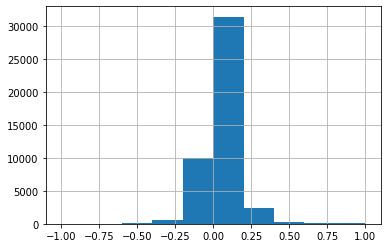

In [30]:
from textblob import TextBlob
data['polarity_score'] = data['text'].apply(lambda x:TextBlob(x).sentiment.polarity)
data['polarity_score'].hist()

- Due to their length, most articles are having polarity score of around zero, suggesting they are neutral.

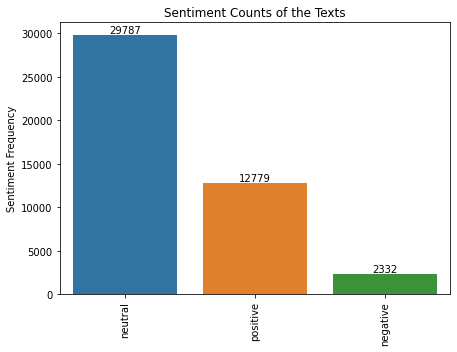

In [31]:
def get_sentiment(pol):
    if pol >= 0.1:
        return 'positive'
    elif pol <= -0.1:
        return 'negative'
    return 'neutral'

data['sentiment']= data['polarity_score'].apply(lambda x:get_sentiment(x))

h, v = zip(*data['sentiment'].value_counts().items())
_ = plot_bar_chart(h, v, ylabel="Sentiment Frequency", 
               title="Sentiment Counts of the Texts")

- Apply some thresholds, we can see that most artciles are either neutral or positives, which seems like promotion campaign for elections.

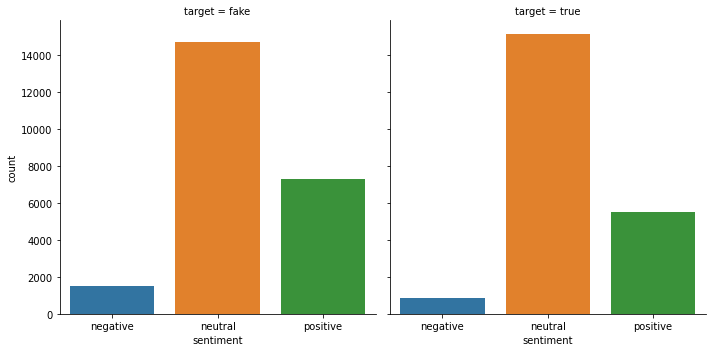

In [32]:
sent_df = data.groupby(['target', 'sentiment'])['text'].count().reset_index(name="count")
sns.catplot(data=sent_df, x="sentiment", y="count", col="target", kind="bar")

- there are little more negative & positives articles in fake news rather than the true ones. neutral ones seems to proportionately distrubuted. As there is no significant difference - we can safely ignore these features for now.

### Machine Learning Models - True v/s Fake News Classification

In [33]:
data = data.dropna(subset=['text_words']).reset_index(drop=1)

In [34]:
from sklearn.model_selection import train_test_split

X = data['text_words']
y = data['target']

# split into train & val datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, 
                                                  stratify = y, random_state=2023)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((33673,), (11225,), (33673,), (11225,))

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=0.01, max_df=0.99, ngram_range=(1,3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_train_tfidf.shape, X_val_tfidf.shape

((33673, 3507), (11225, 3507))

- Extracting top 10 tfidf features to see which features are having good weights for the classification (most significant tfidf features).

In [36]:
def extract_top_tfidf_features(X_tfidf, y_train, feature_names, labels, topn):
    
    imp_dfs = {}
    
    for label in labels:
        label_idx = np.where(y_train.values == label)
        feat_score = X_tfidf[label_idx].toarray().mean(axis = 0)
        topn_idx = np.argsort(feat_score)[::-1][:topn]
        topn_features = [(feature_names[i], feat_score[i]) for i in topn_idx]
        topn_df = pd.DataFrame(topn_features, columns = ['word_name', 'tfidf_value'])
        imp_dfs[label] = topn_df
        
    return imp_dfs

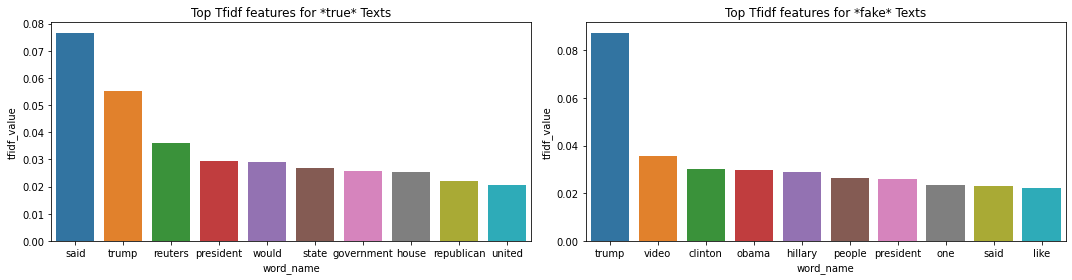

In [37]:
feature_names = np.array(tfidf.get_feature_names_out())
label_names = ["true", "fake"]
out_dfs = extract_top_tfidf_features(X_train_tfidf, y_train, 
                                feature_names, label_names, topn = 10)

plt.figure(figsize=(15,4))
for i, label in enumerate(label_names):
    plt.subplot(1, 2, i + 1)
    sns.barplot(x=out_dfs[label].word_name, y=out_dfs[label].tfidf_value)
    plt.title("Top Tfidf features for *{}* Texts".format(label))
    plt.tight_layout()

- For true news, "reuters" is having weightage."Reuters" being a trusted source of publication there is more likely chance that the news is vetted and true. (which wont be the case with fake news).

#### ML model training & validatiion.

In [38]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

classifier_dict = { 'naive-bayes': MultinomialNB(),
                   'knn-classifier':KNeighborsClassifier(),
                   'logistic-regression': LogisticRegression(solver="saga", n_jobs = -1), 
                   # 'linear-SVC': LinearSVC(max_iter=10**4),
                   'decision-tree':DecisionTreeClassifier(),
                   'random-forest': RandomForestClassifier(n_jobs = -1),
                   'adaBoost-classifier':AdaBoostClassifier(),}

In [39]:
val_auc = {}

# iterate over classifiers
for key in classifier_dict:
    print('*'*60)
    clf = classifier_dict[key]
    clf.fit(X_train_tfidf, y_train)
    classifier_dict[key] = clf
    
    print('Trained {} Model...'.format(key))
    # get predictions & metrics on validation data
    y_val_pred = clf.predict(X_val_tfidf)
    acc = metrics.accuracy_score(y_val, y_val_pred)

    y_val_proba = clf.predict_proba(X_val_tfidf)[:, 1]
    auc = metrics.roc_auc_score(y_val, y_val_proba)

  
    
    print("Validation Results:")
    print(f'Accuracy: {round(acc,3)}  AUC-ROC: {round(auc,3)}',)
    val_auc[key] = auc

************************************************************
Trained naive-bayes Model...
Validation Results:
Accuracy: 0.946  AUC-ROC: 0.986
************************************************************
Trained knn-classifier Model...
Validation Results:
Accuracy: 0.896  AUC-ROC: 0.959
************************************************************
Trained logistic-regression Model...
Validation Results:
Accuracy: 0.989  AUC-ROC: 0.999
************************************************************
Trained decision-tree Model...
Validation Results:
Accuracy: 0.997  AUC-ROC: 0.996
************************************************************
Trained random-forest Model...
Validation Results:
Accuracy: 0.998  AUC-ROC: 1.0
************************************************************
Trained adaBoost-classifier Model...
Validation Results:
Accuracy: 0.998  AUC-ROC: 1.0


In [40]:
best_key = max(val_auc, key=lambda x: val_auc[x])
best_model = classifier_dict[best_key]
print(f"Model with Best AUC-ROC Score: {best_key}")

Model with Best AUC-ROC Score: random-forest


AUC-ROC Score on Validation dataset =  0.999929151645193

ROC Curve:


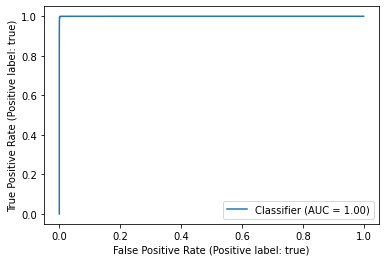

In [41]:
y_val_pred = best_model.predict(X_val_tfidf)
y_val_proba = best_model.predict_proba(X_val_tfidf)[:, 1]
auc_roc = metrics.roc_auc_score(y_val, y_val_proba)

print("AUC-ROC Score on Validation dataset = ",auc_roc)

print("\nROC Curve:")
ax = metrics.RocCurveDisplay.from_predictions(y_val, y_val_proba, 
                                    pos_label=best_model.classes_[1])
plt.show()

Confusion Matrix:


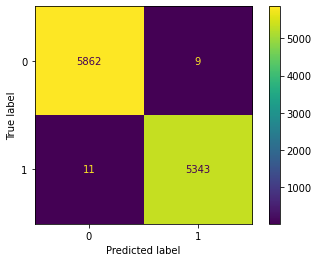

In [42]:
print("Confusion Matrix:")
cm = metrics.confusion_matrix(y_val, y_val_pred, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

- Plotting the feature importance according to the random forest model (best one)

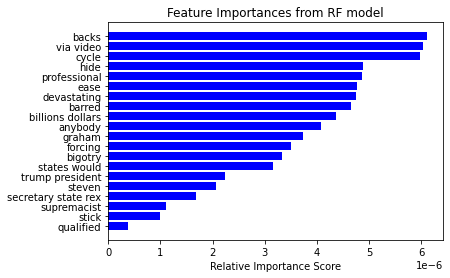

In [43]:
feature_names = np.array(tfidf.get_feature_names_out())
mode_imp = best_model.feature_importances_
top_idx = np.argsort(mode_imp)[:20]
top_feat_names = [feature_names[i] for i in top_idx]

plt.barh(range(0, len(top_idx)), mode_imp[top_idx], color='b', align='center')
plt.title('Feature Importances from RF model')
plt.yticks(range(0, len(top_idx)), top_feat_names)
plt.xlabel('Relative Importance Score')
plt.show()

- The model is primarily relying on above words to classify the articles into either true or fake.

In [44]:
# import shap
# X_val_array = X_val_tfidf.toarray()
# exp = shap.TreeExplainer(best_model)
# shap_values = exp.shap_values(X_val_array)
# shap.summary_plot(shap_values, X_val_array, feature_names=tfidf.get_feature_names())